In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import opensmile
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import io
from PIL import Image
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import random

In [2]:
# FROM https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN

def seed_everything(seed=4):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(4)

In [3]:
SUMMARY_TABLE_PATH = "./CREMA-D/processedResults/summaryTable.csv"
FINISHED_RESPONSES_PATH = "./CREMA-D/finishedResponses.csv"
TABULATED_VOTES_PATH = "./CREMA-D/processedResults/tabulatedVotes.csv"
FRAME_OUTPUT_DIRECTORY = "/home2/jxrs34/final_year_project/output_resized_28_rgb_frames"

## Explore number of frames of entire dataset

In [71]:
face_files_to_ignore = []

In [73]:
root = FRAME_OUTPUT_DIRECTORY

frames = []
for file in os.listdir(root):
    filePath = root + '/' + file
    if os.path.isdir(filePath):
        # ignore files with ambiguous vote
        # note folders are of form e.g. '1001_IEO_SAD_HI_aligned'
        if file[:-8] not in face_files_to_ignore:
            frames.append((len(os.listdir(filePath)), file))

In [74]:

print(max(frames))
print(min(frames))
print(sum([i for i,_ in frames])/len(frames))

# Number of files with less than n OR EQUAL TO frames
def num_files_lte_n_frames(n=15):
    arr = []
    for (frame, name) in frames:
        if int(frame)<=n:
            arr.append((frame, name))
    return len(arr)

def num_files_gt_n_frames(n=15):
    arr = []
    for (frame, name) in frames:
        if int(frame)>n:
            arr.append((frame, name))
    return len(arr)

n_lte = 75
n_gt = 75
print(f'{num_files_lte_n_frames(n_lte)} files have at most {n_lte} frames')
print(f'{num_files_gt_n_frames(n_gt)} files have more than {n_gt} frames')
print(f'{num_files_gt_n_frames(n_gt*2)} files have more than {n_gt*2} frames')

(1851, '1064_IEO_DIS_MD_aligned')
(2, '1076_MTI_NEU_XX_aligned')
76.66487503359312
3868 files have at most 75 frames
3574 files have more than 75 frames
2 files have more than 150 frames


In [105]:
frames_df = pd.DataFrame(frames, columns=["frames", "file_name"])
frames_df

,frames,file_name
0,67,1001_DFA_ANG_XX_aligned
1,70,1001_DFA_DIS_XX_aligned
2,65,1001_DFA_FEA_XX_aligned
3,56,1001_DFA_HAP_XX_aligned
4,61,1001_DFA_NEU_XX_aligned
...,...,...
7437,75,1091_WSI_DIS_XX_aligned
7438,75,1091_WSI_FEA_XX_aligned
7439,65,1091_WSI_HAP_XX_aligned
7440,70,1091_WSI_NEU_XX_aligned


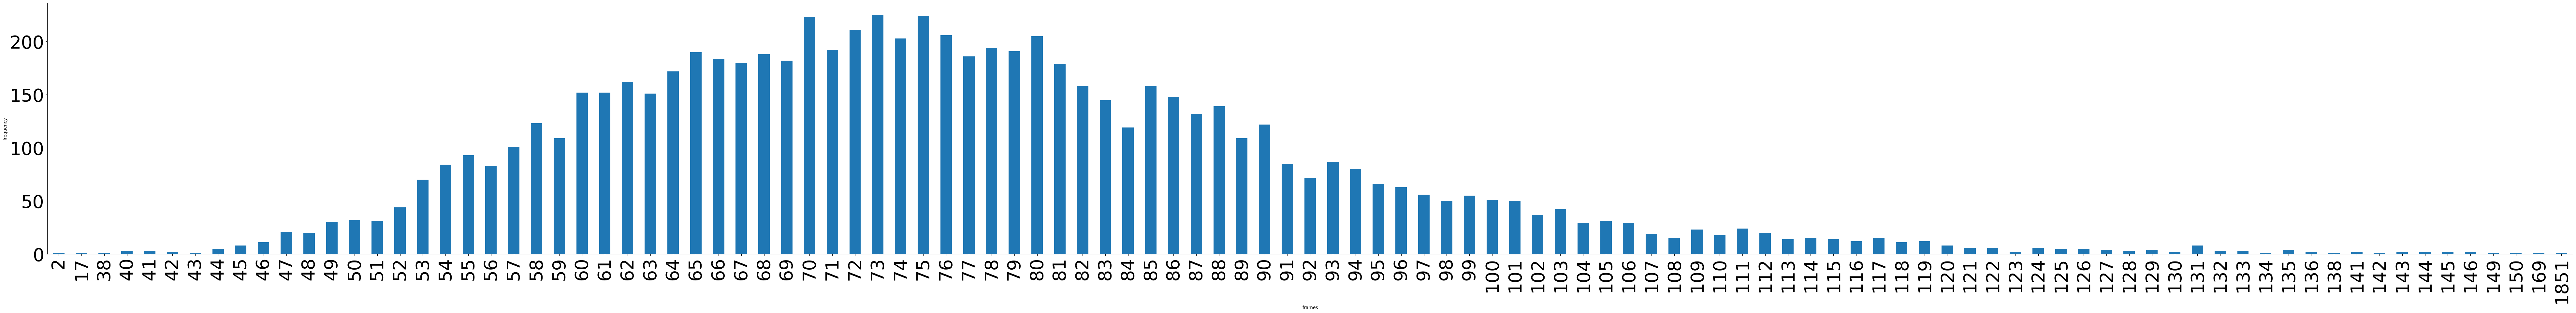

In [106]:
frames_df['frames'].value_counts().sort_index().plot(kind='bar', xlabel='frames', ylabel='frequency', figsize=(100,10), fontsize=40)
plt.show()

## Custom datalaoder to load in data

In [5]:
labelencoder = pd.read_pickle("label_encoder.pkl")

In [6]:
bal_face_train = pd.read_pickle("./balanced_face_train.pkl")

In [7]:
bal_face_train

,fileName,intendedEmo
0,1088_IWW_NEU_XX,4
1,1065_ITH_DIS_XX,1
2,1088_IWW_ANG_XX,0
3,1072_ITH_DIS_XX,1
4,1038_ITH_DIS_XX,1
...,...,...
5101,1028_TSI_SAD_XX,5
5102,1039_IWL_SAD_XX,5
5103,1004_IEO_SAD_MD,5
5104,1024_TIE_SAD_XX,5


In [8]:
combined_face_votes_incorrect = pd.read_pickle("./combined_face_votes_incorrect")

face_mismatch_fname_emo = combined_face_votes_incorrect[["fileName", "intendedEmo"]]
face_mismatch_fname_emo["intendedEmo"] = labelencoder.fit_transform(face_mismatch_fname_emo["intendedEmo"])
face_mismatch_fname_emo

/tmp/ipykernel_3562529/1715500612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_mismatch_fname_emo["intendedEmo"] = labelencoder.fit_transform(face_mismatch_fname_emo["intendedEmo"])


,fileName,intendedEmo
4,1001_IEO_SAD_LO,5
5,1001_IEO_SAD_MD,5
6,1001_IEO_SAD_HI,5
7,1001_IEO_ANG_LO,0
10,1001_IEO_FEA_LO,2
...,...,...
7422,1091_DFA_FEA_XX,2
7426,1091_ITS_SAD_XX,5
7429,1091_ITS_DIS_XX,1
7432,1091_TSI_SAD_XX,5


In [9]:
BATCH_SIZE = 4
TRANSFORMATIONS = torchvision.transforms.Compose([
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.ToTensor(),
                                           ])
TEST_TRANSFORMATIONS = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                           ])

In [10]:
class OpenFaceFramesDataset(Dataset):
    def __init__(self, dataset, root_dir=FRAME_OUTPUT_DIRECTORY, transform=None):
        """
        Args:
            dataset_path (string): Path to the dataset with file names and emotion.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = dataset
        self.root_dir = root_dir
        self.transform = transform
        self.NUM_FRAMES = 75

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = {'frames': [], 'labels': []}
        folder_path = os.path.join(self.root_dir, self.dataset.iloc[idx, 0] + "_aligned")
        # sanity check to make sure its a directory
        if os.path.isdir(folder_path):
            frames = []
            file_list = [files for files in os.listdir(folder_path)]
            equal_frame_file_list = file_list

            # convert the files list to a dictionary
            filelist_dict = { ind: name for (ind,name) in enumerate(file_list) }
            if len(file_list) < self.NUM_FRAMES:
                # duplicate last frame
                last_duplicated = [file_list[-1]] * (self.NUM_FRAMES-len(file_list))
                equal_frame_file_list = file_list + last_duplicated
            elif len(file_list) > self.NUM_FRAMES:
                increment = len(file_list)//self.NUM_FRAMES
                # Get indexes of frames that are equally spaced
                frame_indexes = [increment*n for n in range(self.NUM_FRAMES)]
                equal_frame_file_list = [filelist_dict[index] for index in frame_indexes]
            
            for image_file in equal_frame_file_list:
                image = Image.open(folder_path + "/" + image_file)
                # channels x height x width
                image_tensor = self.transform(image) if self.transform else torchvision.transforms.ToTensor()(image)
                frames.append(image_tensor)
            frames_tensor = torch.stack(frames)
            sample = {'frames': frames_tensor, 'labels': self.dataset.iloc[idx, 1]}
        return sample

## Create exploratory DataLoaders to calculate mean and std

In [11]:
transformed_dataset = OpenFaceFramesDataset(dataset=bal_face_train,
                                            root_dir=FRAME_OUTPUT_DIRECTORY,
                                            transform=TRANSFORMATIONS)
train_loader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, drop_last=True)

emotion shown: ['S']


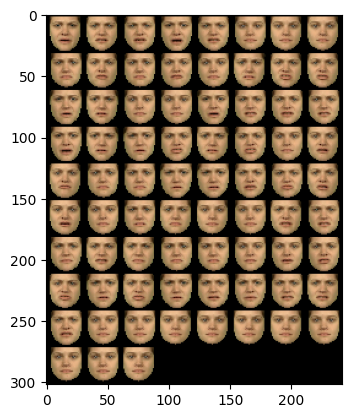

In [12]:
random_sample = next(iter(train_loader))
random_sample_frames = random_sample['frames'][0]
print(f'emotion shown: {labelencoder.inverse_transform([random_sample["labels"][0]])}')
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(random_sample_frames).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [13]:
face_val = pd.read_pickle("face_val.pkl")

In [14]:
face_val

,fileName,intendedEmo
0,1087_TSI_NEU_XX,4
1,1077_IWW_HAP_XX,3
2,1065_IEO_ANG_HI,0
3,1071_IOM_HAP_XX,3
4,1064_ITH_NEU_XX,4
...,...,...
735,1076_IEO_FEA_HI,2
736,1072_TIE_ANG_XX,0
737,1018_TAI_FEA_XX,2
738,1032_TIE_DIS_XX,1


In [15]:
bal_face_train

,fileName,intendedEmo
0,1088_IWW_NEU_XX,4
1,1065_ITH_DIS_XX,1
2,1088_IWW_ANG_XX,0
3,1072_ITH_DIS_XX,1
4,1038_ITH_DIS_XX,1
...,...,...
5101,1028_TSI_SAD_XX,5
5102,1039_IWL_SAD_XX,5
5103,1004_IEO_SAD_MD,5
5104,1024_TIE_SAD_XX,5


In [16]:
val_dataset = OpenFaceFramesDataset(dataset=face_val,
                                    root_dir=FRAME_OUTPUT_DIRECTORY,
                                    transform=TEST_TRANSFORMATIONS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, drop_last=True)

emotion shown: ['A']


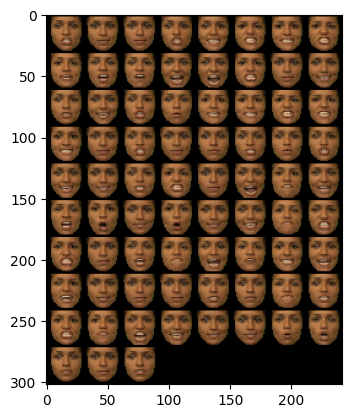

In [17]:
random_sample = next(iter(val_loader))
random_sample_frames = random_sample['frames'][0]
print(f'emotion shown: {labelencoder.inverse_transform([random_sample["labels"][0]])}')
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(random_sample_frames).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [18]:
face_test = pd.read_pickle("face_test.pkl")

In [19]:
test_dataset = OpenFaceFramesDataset(dataset=face_test,
                                    root_dir=FRAME_OUTPUT_DIRECTORY,
                                    transform=TEST_TRANSFORMATIONS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, drop_last=True)

emotion shown: ['H']


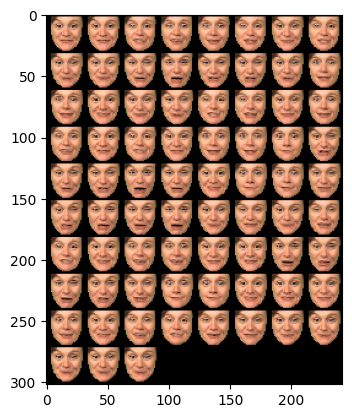

In [20]:
random_sample = next(iter(test_loader))
random_sample_frames = random_sample['frames'][0]
print(f'emotion shown: {labelencoder.inverse_transform([random_sample["labels"][0]])}')
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(random_sample_frames).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

emotion shown: ['D']


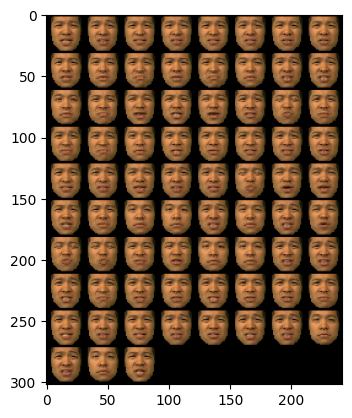

In [21]:
mismatch_test_dataset = OpenFaceFramesDataset(dataset=face_mismatch_fname_emo,
                                    root_dir=FRAME_OUTPUT_DIRECTORY,
                                    transform=TEST_TRANSFORMATIONS)
mismatch_test_loader = DataLoader(mismatch_test_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, drop_last=True)

random_sample = next(iter(mismatch_test_loader))
random_sample_frames = random_sample['frames'][0]
print(f'emotion shown: {labelencoder.inverse_transform([random_sample["labels"][0]])}')
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(random_sample_frames).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [22]:
def get_mean_std(loader):
    # Adapted from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/pytorch_std_mean.py
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data in tqdm(loader):
        channels_sum += torch.mean(data["frames"], dim=[0, 1, 3, 4])
        channels_sqrd_sum += torch.mean(data["frames"]**2, dim=[0, 1, 3, 4])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean**2) ** 0.5

    return mean, std


# train_mean, train_std = get_mean_std(train_loader)
# val_mean, val_std = get_mean_std(val_loader)
# test_mean, test_std = get_mean_std(test_loader)
# mismtach_test_mean, mismatch_test_std = get_mean_std(mismatch_test_loader)

In [23]:
# print(f'{train_mean} {train_std}')
# print(f'{val_mean} {val_std}')
# print(f'{test_mean} {test_std}')
# print(f'{mismtach_test_mean} {mismatch_test_std}')


# Outputs:
# tensor([0.5114, 0.3726, 0.2483]) tensor([0.3421, 0.2565, 0.1863])
# tensor([0.5327, 0.3879, 0.2578]) tensor([0.3316, 0.2488, 0.1824])
# tensor([0.5327, 0.3879, 0.2578]) tensor([0.3316, 0.2488, 0.1824])
# tensor([0.5282, 0.3842, 0.2541]) tensor([0.3322, 0.2485, 0.1801])

### Create DataLoaders to be used for training and testing

In [24]:
TRAIN_NORM_TRANSFORMATIONS = torchvision.transforms.Compose([
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                [0.5114, 0.3726, 0.2483],
                                                [0.3421, 0.2565, 0.1863]
                                            ),
                                           ])
VAL_NORM_TRANSFORMATIONS = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                [0.5327, 0.3879, 0.2578],
                                                [0.3316, 0.2488, 0.1824]
                                            )
                                           ])
TEST_NORM_TRANSFORMATIONS = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                [0.5327, 0.3879, 0.2578],
                                                [0.3316, 0.2488, 0.1824]
                                            )
                                           ])

MISMATCH_TEST_NORM_TRANSFORMATIONS = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                [0.5282, 0.3842, 0.2541],
                                                [0.3322, 0.2485, 0.1801]
                                            )
                                           ])

train_norm_dataset = OpenFaceFramesDataset(dataset=bal_face_train,
                                            root_dir=FRAME_OUTPUT_DIRECTORY,
                                            transform=TRAIN_NORM_TRANSFORMATIONS)
train_norm_loader = DataLoader(train_norm_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, drop_last=True)


val_norm_dataset = OpenFaceFramesDataset(dataset=face_val,
                                    root_dir=FRAME_OUTPUT_DIRECTORY,
                                    transform=VAL_NORM_TRANSFORMATIONS)
val_norm_loader = DataLoader(val_norm_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, drop_last=True)

test_norm_dataset = OpenFaceFramesDataset(dataset=face_test,
                                    root_dir=FRAME_OUTPUT_DIRECTORY,
                                    transform=TEST_NORM_TRANSFORMATIONS)
test_norm_loader = DataLoader(test_norm_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, drop_last=True)

mismatch_test_norm_dataset = OpenFaceFramesDataset(dataset=face_mismatch_fname_emo,
                                    root_dir=FRAME_OUTPUT_DIRECTORY,
                                    transform=MISMATCH_TEST_NORM_TRANSFORMATIONS)
mismatch_test_norm_loader = DataLoader(mismatch_test_norm_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0, drop_last=True)

## Build model

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
DROPOUT_PROB_1 = 0.07

class fiveLayerCNNLSTM(nn.Module):
    def __init__(self):
        super(fiveLayerCNNLSTM, self).__init__()
        self.cnn_layers = nn.Sequential(
            # required shape (N, channels(3), frames, h, w)
            nn.Conv3d(in_channels=3, out_channels=32, kernel_size=(3,3,3)),
            nn.LeakyReLU(negative_slope=0.1, inplace=False),
            nn.BatchNorm3d(32),
            nn.Dropout3d(p=DROPOUT_PROB_1),
        )

        self.lstm = nn.LSTM(
                input_size=26*26*32,
                hidden_size=64,
                num_layers=1,
                dropout=0.14,
                # batch_first=True # expect (batch, timestamps, input_features) instead of default (timesteps, batch, input_features)
            )
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(negative_slope=0.1, inplace=False),
            nn.Dropout(p=0.21),

            nn.Linear(in_features=32, out_features=6),
#             nn.Softmax()
        )
    
    def forward(self, x):
        x = torch.permute(x, (0,2,1,3,4)) #torch.Size([4, 3, 75, 28, 28])
        cnn_output = self.cnn_layers(x)
        lstm_output, (hidden_n, cell_n) = self.lstm(cnn_output.view(73, BATCH_SIZE, -1))
        # lstm_output[-1,:,:] has shape torch.Size([batch_size, 64])
        output = self.output_layer(lstm_output[-1,:,:])
        return output

In [27]:
DROPOUT_PROB_1 = 0.07

class sixLayerCNNLSTM(nn.Module):
    def __init__(self):
        super(sixLayerCNNLSTM, self).__init__()

        self.cnn_layers = nn.Sequential(
                self.conv_block(in_channels=3, out_channels=32), # [4, 32, 73, 26, 26]
                self.conv_block(in_channels=32, out_channels=64), # [4, 64, 71, 24, 24]
                nn.MaxPool3d((2,2,2)), # [4, 64, 35, 12, 12]
                self.conv_block(in_channels=64, out_channels=128), # [4, 128, 33, 10, 10]
        )

        self.lstm = nn.LSTM(
                    input_size=12800,
                    hidden_size=64,
                    num_layers=1,
                    dropout=0.14,
                    # batch_first=True # expect (batch, timestamps, input_features) instead of default (timesteps, batch, input_features)
        )
        self.output_layer = nn.Sequential(
                nn.Linear(in_features=64, out_features=32),
                nn.LeakyReLU(negative_slope=0.1, inplace=False),
                nn.Dropout(p=0.21),

                nn.Linear(in_features=32, out_features=6),
            )
    def conv_block(self, in_channels=64, out_channels=2):
        return nn.Sequential(
                # required shape (N, channels(3), frames, h, w)
                nn.Conv3d(in_channels, out_channels, kernel_size=(3,3,3)),
                nn.LeakyReLU(negative_slope=0.1, inplace=False),
                nn.BatchNorm3d(out_channels),
                nn.Dropout3d(p=0.07),
        )
    
    def forward(self, x):
        x = torch.permute(x, (0,2,1,3,4)) #torch.Size([4, 3, 75, 28, 28]) 
        # input to conv3d = N, C_in, D (num frames), H, W
        # output has same format
        cnn_output = self.cnn_layers(x)

        # input to LSTM = (L (sequence len), N (batch_size), input size) when batch_first=False
        # 33 is D i.e. the temporal information so will be equal to L the timesteps
        lstm_output, (hidden_n, cell_n) = self.lstm(cnn_output.view(33, BATCH_SIZE, -1))

        output = self.output_layer(lstm_output[-1,:,:])
        return output

## Train model

#### Train val framework adapted From https://colab.research.google.com/drive/1H_XlTbNvjxlAXMW5NuBDWhxF3F2Osg1F?usp=sharing#scrollTo=5Kt7Z-PrKz2g

In [28]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
    From https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


In [29]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv3d:
        torch.nn.init.xavier_uniform(m.weight)

In [ ]:
def train(config, save_file_name):
# Train val framework adapted From https://colab.research.google.com/drive/1H_XlTbNvjxlAXMW5NuBDWhxF3F2Osg1F?usp=sharing#scrollTo=5Kt7Z-PrKz2g
    NUM_EPOCHS = config["maxEpochs"]
    BATCH_SIZE = 4
    LEARNING_RATE = config["lr"]
    if config["network"] == "sixLayerCNNLSTM":
        net = sixLayerCNNLSTM().to(device)
    elif config["network"] == "fiveLayerCNNLSTM":
        net = fiveLayerCNNLSTM().to(device)
    net.apply(reset_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=LEARNING_RATE,
        betas=(0.99, 0.999),
    )
    epoch_arr = []
    train_acc_arr = []
    train_loss_arr = []
    val_acc_arr = []
    val_loss_arr = []
    best_val_acc = 0
    for epoch in range(NUM_EPOCHS):
        classified_right = 0
        epoch_train_loss = 0.0
        running_train_loss = 0.0
        net.train()
        print(f'Training iteration {epoch+1}')
        for i, data in enumerate(tqdm(train_norm_loader, 0)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['frames'], data['labels']
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            _, pred_classes = torch.max(outputs, 1)
            classified_right += (pred_classes == labels).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            # Gradient clipping to avoid exploding/vanishing gradients
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(bal_face_train)
        train_acc = classified_right / len(bal_face_train)
        net.eval()
        epoch_val_loss = 0.0
        running_val_loss = 0.0
        classified_right = 0
        print('Evaluating on validation set')
        for i, data in enumerate(tqdm(val_norm_loader, 0)):
            with torch.no_grad():
              inputs, labels = data['frames'], data['labels']
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = net(inputs)
              _, pred_classes = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              classified_right += (pred_classes == labels).sum().item()
              running_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_val_loss / len(face_val)
        val_acc = classified_right / len(face_val)
        print(f'Epoch {epoch+1}  Train Acc: {train_acc} Val Acc: {val_acc}')
        
        if val_acc > best_val_acc and epoch>30:
            if not os.path.exists(f'./best_model'):
                os.makedirs(f'./best_model')

            torch.save({
                'model':net.state_dict(),
                'optimizer':optimizer.state_dict(),
                'epoch': epoch,
                'config': config
            }, f'./best_model/{save_file_name}_model_{epoch+1}.chkpt')
        
        # Append results to array
        epoch_arr.append(epoch)
        train_acc_arr.append(train_acc)
        train_loss_arr.append(epoch_train_loss)
        val_acc_arr.append(val_acc)
        val_loss_arr.append(epoch_val_loss)
        
    results = pd.DataFrame({
        "epoch": epoch_arr,
        "train_acc": train_acc_arr,
        "train_loss": train_loss_arr,
        "val_acc": val_acc_arr,
        "val_loss": val_loss_arr,
    })
    
    config_values = dict()
    for key in config.keys():
        config_values[key] = [config[key]]*results.shape[0]
    config_values = pd.DataFrame(config_values)
    results = pd.concat([results, config_values], axis=1)
    
    
    pd.to_pickle(results, f'./results/{save_file_name}_results.pkl')

In [ ]:
# ./results/lr_0.0001_maxEpochs_100_network_sixLayerCNNLSTM_results.pkl resulted in 0.6635135135135135 val accuracy

# param_grid = {'network': ["fiveLayerCNNLSTM", "sixLayerCNNLSTM"], 'lr': [1e-5, 1e-4, 1e-3], 'maxEpochs': [75]}
# for config in ParameterGrid(param_grid):
#     save_file_name = str(config).replace(":", "").replace("'","").replace(",","").replace(" ", "_")[1:-1]
#     print(f'Config: {config}')
#     train(config, save_file_name)


param_grid = {'network': ["sixLayerCNNLSTM"], 'lr': [1e-5], 'maxEpochs': [150]}
for config in ParameterGrid(param_grid):
    save_file_name = str(config).replace(":", "").replace("'","").replace(",","").replace(" ", "_")[1:-1] + '_horiz_flip_gradclip'
    print(f'Config: {config}')
    train(config, save_file_name)

break

In [ ]:
weight_decay_results = pd.read_pickle("./results/lr_0.0001_maxEpochs_100_network_sixLayerCNNLSTM_weightDecay_0.003_horiz_flip_gradclip_results.pkl")
weight_decay_results

### Plot train results

In [10]:
best_train_results = pd.read_pickle('./results/results_from_horiz_flip_gradclip_150_best/lr_0.0001_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_results.pkl')
best_train_results

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
0,0,0.177047,1.797170,0.198649,0.259896,0.0001,150,sixLayerCNNLSTM
1,1,0.166079,1.793371,0.143243,0.260202,0.0001,150,sixLayerCNNLSTM
2,2,0.167842,1.792536,0.212162,0.258826,0.0001,150,sixLayerCNNLSTM
3,3,0.186251,1.783987,0.185135,0.259775,0.0001,150,sixLayerCNNLSTM
4,4,0.195848,1.774051,0.218919,0.254492,0.0001,150,sixLayerCNNLSTM
...,...,...,...,...,...,...,...,...
145,145,0.980219,0.082187,0.816216,0.244668,0.0001,150,sixLayerCNNLSTM
146,146,0.981590,0.075949,0.814865,0.253718,0.0001,150,sixLayerCNNLSTM
147,147,0.977869,0.095347,0.817568,0.250403,0.0001,150,sixLayerCNNLSTM
148,148,0.981394,0.079916,0.806757,0.255255,0.0001,150,sixLayerCNNLSTM


In [4]:
def plot_train_val_acc(train_accs, val_accs, epochs):
    # Plot and label the training and validation loss values
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')

    # Add in a title and axes labels
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Display the plot
    plt.legend(loc='best')
    plt.show()
    
    
    
def plot_train_val_loss(train_losss, val_losss, epochs):
    # Plot and label the training and validation loss values
    plt.plot(epochs, train_losss, label='Training Loss')
    plt.plot(epochs, val_losss, label='Validation Loss')

    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Display the plot
    plt.legend(loc='best')
    plt.show()

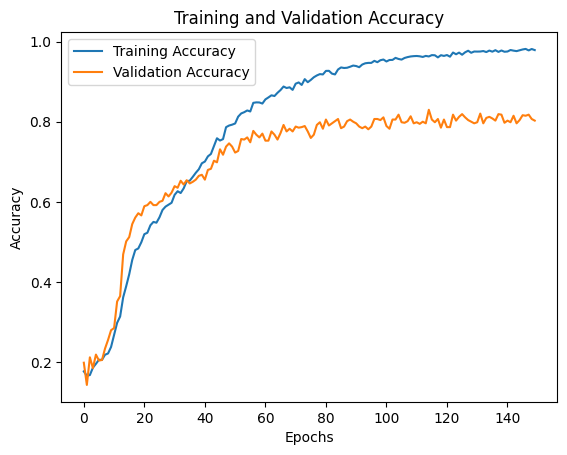

In [11]:
train_accs = list(best_train_results.train_acc)
val_accs = list(best_train_results.val_acc)
epochs = list(best_train_results.epoch)

plot_train_val_acc(train_accs, val_accs, epochs)


# train_losss = list(best_train_results.train_loss)
# val_losss = list(best_train_results.val_loss)

# plot_train_val_loss(train_losss, val_losss, epochs)

In [46]:
best_train_results.loc[best_train_results.val_acc==max(best_train_results.val_acc)]

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
114,114,0.962789,0.146534,0.82973,0.182781,0.0001,150,sixLayerCNNLSTM


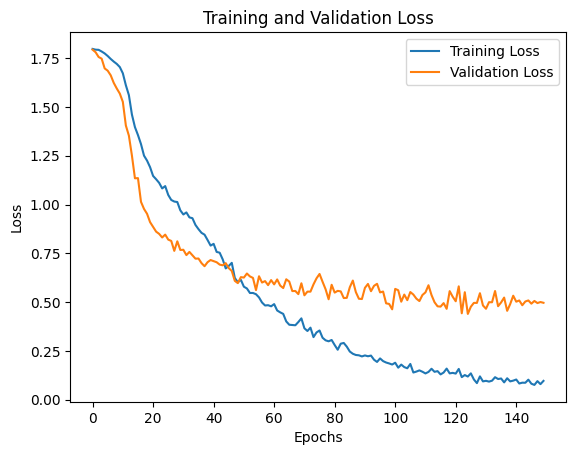

In [47]:
train_losss = list(best_train_results.train_loss)
val_losss = list(best_train_results.val_loss)

plot_train_val_loss(train_losss, val_losss, epochs)

In [48]:
best_train_results.loc[best_train_results.val_acc==max(best_train_results.val_acc)]

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
114,114,0.962789,0.146534,0.82973,"(0.4785734162139975,)",0.0001,150,sixLayerCNNLSTM


In [12]:
import seaborn as sns

def plot_cm(trues, preds, targets, title):
    # adapted from https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix


    all_face_cm = confusion_matrix(trues, preds, labels=targets, normalize='true')

    all_face_cm / all_face_cm.astype(np.float).sum(axis=1)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(all_face_cm, annot=True, fmt='.2f', xticklabels=targets, yticklabels=targets)
    plt.ylabel('Intended Emotion')
    plt.xlabel('Predicted emotion by CNN-LSTM model')
    plt.title(title)
    plt.show(block=False)

TARGET_NAMES = ["A", "D", "F", "H", "N", "S"]

from sklearn.metrics import confusion_matrix

def test(model, path, test_loader): 
    model.apply(reset_weights)
    # FROM https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model
    # Load the model that we saved at the end of the training loop 
    model.load_state_dict(torch.load(path)["model"]) 
     
    running_accuracy = 0 
    total = 0 
 
    model.eval()
    
    # Initialize the prediction and label lists(tensors)
    pred_arr=torch.zeros(0,dtype=torch.long, device='cpu')
    label_arr=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad(): 
        for data in tqdm(test_loader): 
            inputs, labels = data['frames'], data['labels']
            inputs = inputs.to(device)
            labels = labels.to(device)
            predicted_outputs = model(inputs) 
            _, predicted = torch.max(predicted_outputs, 1) 
        
            # Append batch prediction results
            # inspired by https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
            pred_arr=torch.cat([pred_arr, predicted.view(-1).cpu()])
            label_arr=torch.cat([label_arr, labels.view(-1).cpu()])
            
            
            total += labels.size(0) 
            running_accuracy += (predicted == labels).sum().item() 
        print(f'Accuracy of the model based on the test set is: {(100 * running_accuracy / total)}')    
        
        return label_arr, pred_arr

In [ ]:
net = sixLayerCNNLSTM().to(device)
# path = "./best_model/lr_0.0001_maxEpochs_100_network_sixLayerCNNLSTM_horiz_flip_gradclip_model_100.chkpt"
path = "./best_model/lr_0.0001_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_model_114.chkpt"
y_test_match, y_pred_match = test(net, path, test_norm_loader)
match_trues = labelencoder.inverse_transform(y_test_match)
match_preds = labelencoder.inverse_transform(y_pred_match)

plot_cm(match_trues, match_preds, TARGET_NAMES, "Confusion matrix of CNN-LSTM results on matched data")

In [ ]:
# match_test_res = pd.DataFrame({
#     "preds": match_preds,
#     "trues": match_trues
# })
# pd.to_pickle(match_test_res, "./test_results/visual_matching_results_df")
# #80.8108108108108

Accuracy: 80.8108108108108


/tmp/ipykernel_1422287/2374597053.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_face_cm / all_face_cm.astype(np.float).sum(axis=1)


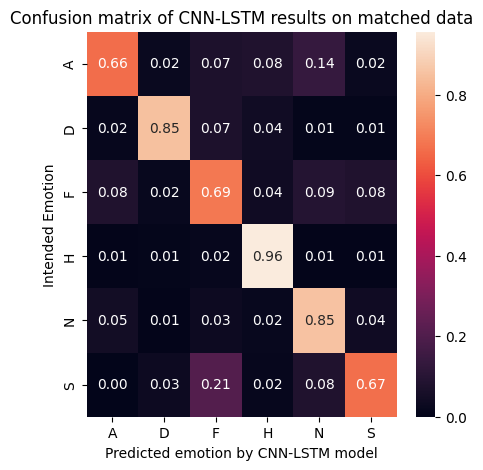

In [17]:
match_test_res = pd.read_pickle("./test_results/visual_matching_results_df")
match_acc = len(match_test_res.loc[match_test_res.trues==match_test_res.preds])/len(match_test_res)
print(f'Accuracy: {match_acc*100}')
plot_cm(match_test_res.trues, match_test_res.preds, TARGET_NAMES, "Confusion matrix of CNN-LSTM results on matched data")

In [ ]:
y_test_mismatch, y_pred_mismatch = test(net, path, mismatch_test_norm_loader)
mismatch_trues = labelencoder.inverse_transform(y_test_mismatch)
mismatch_preds = labelencoder.inverse_transform(y_pred_mismatch)
plot_cm(mismatch_trues, mismatch_preds, TARGET_NAMES, "Confusion matrix of CNN-LSTM results on mismatched+ambiguous data")

In [ ]:
mismatch_test_res = pd.DataFrame({
    "preds": mismatch_preds,
    "trues": mismatch_trues
})
pd.to_pickle(mismatch_test_res, "./test_results/visual_mismatching_results_df")
# # 38.95534290271132 

Accuracy: 38.95534290271133


/tmp/ipykernel_1422287/2374597053.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_face_cm / all_face_cm.astype(np.float).sum(axis=1)


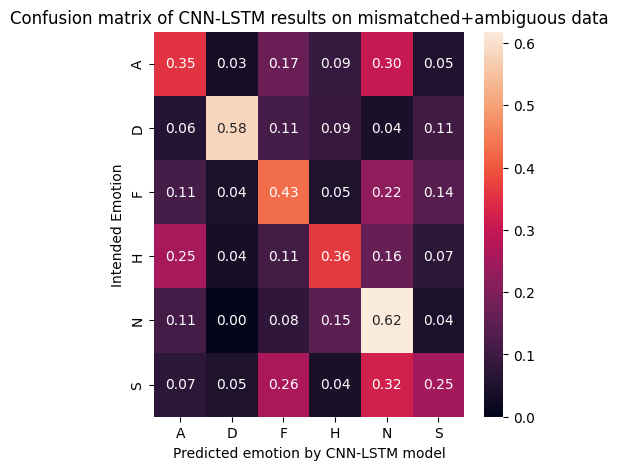

In [19]:
mismatch_test_res = pd.read_pickle("./test_results/visual_mismatching_results_df")
mismatch_acc = len(mismatch_test_res.loc[mismatch_test_res.trues==mismatch_test_res.preds])/len(mismatch_test_res)
print(f'Accuracy: {mismatch_acc*100}')
plot_cm(mismatch_test_res.trues, mismatch_test_res.preds, TARGET_NAMES, "Confusion matrix of CNN-LSTM results on mismatched+ambiguous data")

### Testing will less overfitting model

In [ ]:
best_train_results.iloc[60:80]#.loc[best_train_results.val_acc]

In [ ]:
net = sixLayerCNNLSTM().to(device)
net.apply(reset_weights)

less_overfit_mdl_path = "./best_model/lr_0.0001_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_model_66.chkpt"
less_ovrft_mdl_y_test_match, less_ovrft_mdl_y_pred_match = test(net, less_overfit_mdl_path, test_norm_loader)
less_overfit_mdl_match_trues = labelencoder.inverse_transform(less_ovrft_mdl_y_test_match)
less_overfit_mdl_match_preds = labelencoder.inverse_transform(less_ovrft_mdl_y_pred_match)

plot_cm(less_overfit_mdl_match_trues, less_overfit_mdl_match_preds, TARGET_NAMES, "Confusion matrix of CNN-LSTM results on matched data")

In [ ]:
!ls ./results

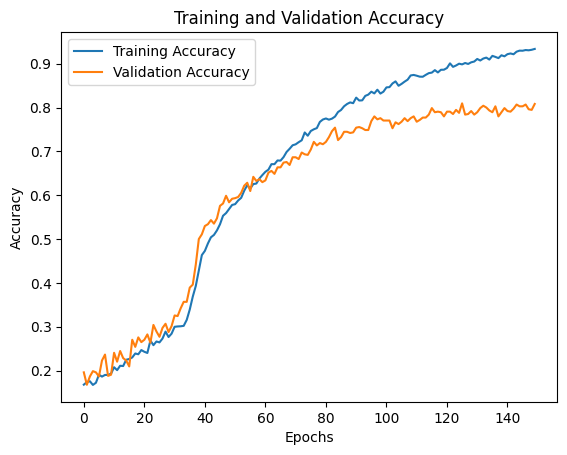

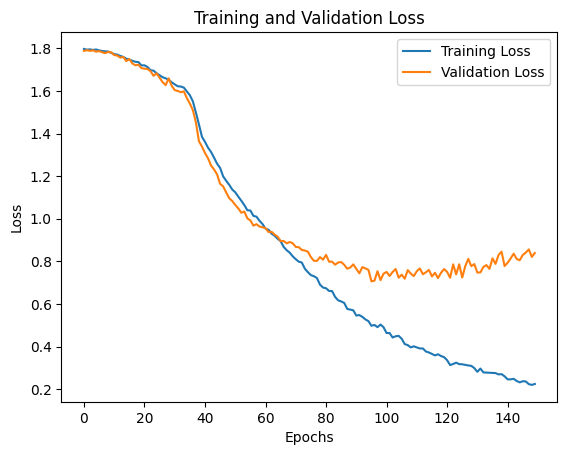

In [50]:
# !ls ./results
random_train_results = pd.read_pickle('./results/lr_1e-05_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_results.pkl')

random_train_accs = list(random_train_results.train_acc)
random_val_accs = list(random_train_results.val_acc)
random_epochs = list(random_train_results.epoch)

plot_train_val_acc(random_train_accs, random_val_accs, random_epochs)


random_train_losss = list(random_train_results.train_loss)
random_val_losss = list(random_train_results.val_loss)

plot_train_val_loss(random_train_losss, random_val_losss, random_epochs)

In [51]:
random_train_results
random_train_results.loc[random_train_results.val_acc == max(random_train_results.val_acc)]

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
125,125,0.898355,0.316876,0.809459,0.724039,0.00001,150,sixLayerCNNLSTM


/home2/jxrs34/myjupyterenv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Reset trainable parameters of layer = Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=6, bias=True)
Reset trainable parameters of layer = LSTM(12800, 64, dropout=0.14)
Reset trainable parameters of layer = Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameter

100%|██████████| 185/185 [00:44<00:00,  4.14it/s]
/tmp/ipykernel_3562529/2374597053.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_face_cm / all_face_cm.astype(np.float).sum(axis=1)


Accuracy of the model based on the test set is: 79.05405405405405


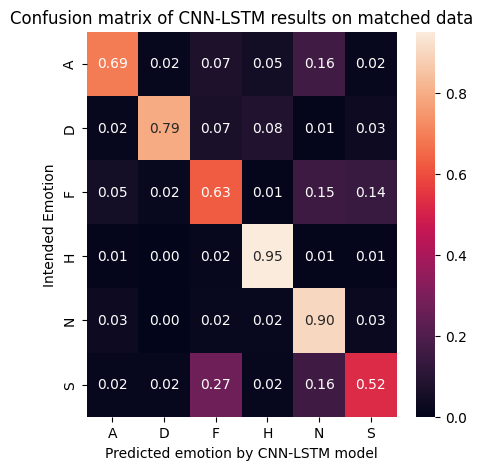

In [54]:
path = "./best_model/lr_1e-05_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_model_125.chkpt"
net = sixLayerCNNLSTM().to(device)
net.apply(reset_weights)

y_test_match, y_pred_match = test(net, path, test_norm_loader)
match_trues = labelencoder.inverse_transform(y_test_match)
match_preds = labelencoder.inverse_transform(y_pred_match)

plot_cm(match_trues, match_preds, TARGET_NAMES, "Confusion matrix of CNN-LSTM results on matched data")

Reset trainable parameters of layer = Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
Reset trainable parameters of layer = BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=6, bias=True)
Reset trainable parameters of layer = LSTM(12800, 64, dropout=0.14)


100%|██████████| 627/627 [02:30<00:00,  4.18it/s]
/tmp/ipykernel_3562529/2374597053.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_face_cm / all_face_cm.astype(np.float).sum(axis=1)


Accuracy of the model based on the test set is: 32.77511961722488


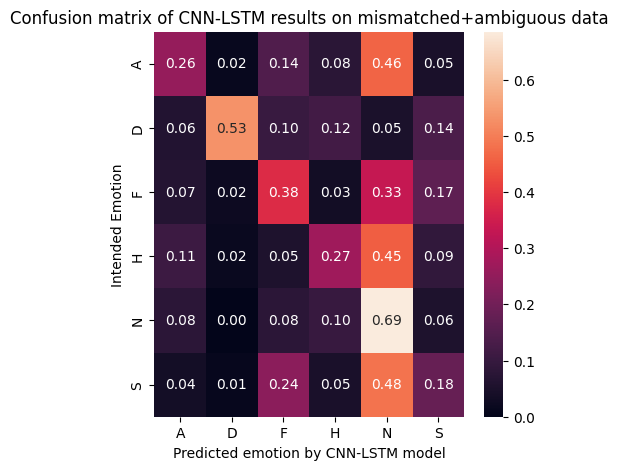

In [42]:
y_test_mismatch, y_pred_mismatch = test(net, path, mismatch_test_norm_loader)
mismatch_trues = labelencoder.inverse_transform(y_test_mismatch)
mismatch_preds = labelencoder.inverse_transform(y_pred_mismatch)
plot_cm(mismatch_trues, mismatch_preds, TARGET_NAMES, "Confusion matrix of CNN-LSTM results on mismatched+ambiguous data")

## Plot other results

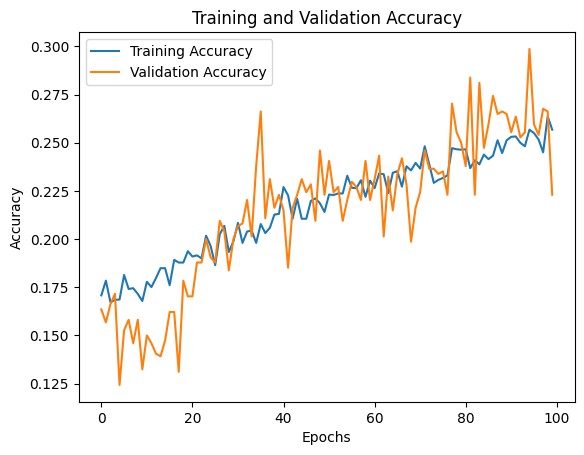

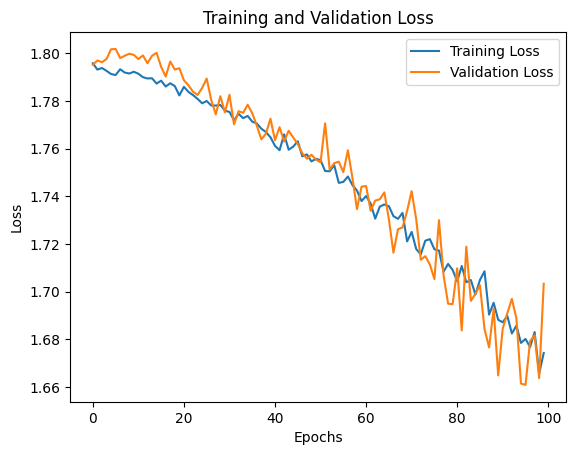

In [5]:
fle05_train_results = pd.read_pickle('./results/lr_1e-05_maxEpochs_100_network_fiveLayerCNNLSTM_horiz_flip_gradclip_results.pkl')

fle05_train_accs = list(fle05_train_results.train_acc)
fle05_val_accs = list(fle05_train_results.val_acc)
fle05_epochs = list(fle05_train_results.epoch)

plot_train_val_acc(fle05_train_accs, fle05_val_accs, fle05_epochs)


fle05_train_losss = list(fle05_train_results.train_loss)
fle05_val_losss = list(fle05_train_results.val_loss)

plot_train_val_loss(fle05_train_losss, fle05_val_losss, fle05_epochs)

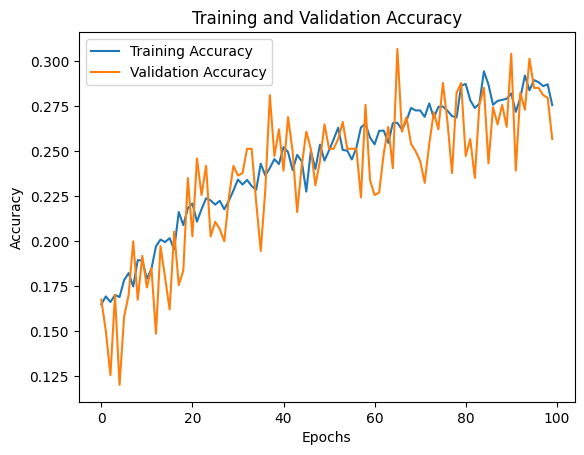

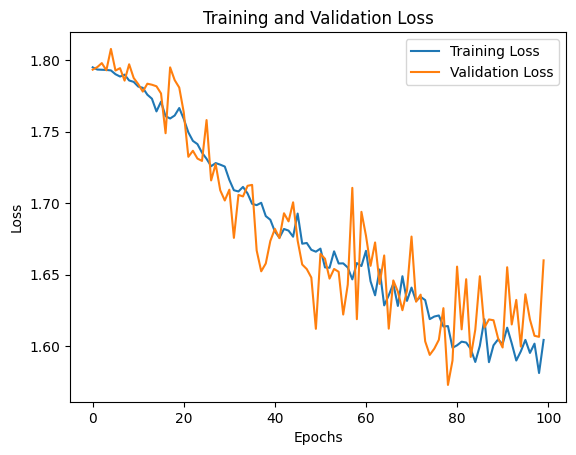

In [9]:
fle04_train_results = pd.read_pickle('./results/lr_0.0001_maxEpochs_100_network_fiveLayerCNNLSTM_horiz_flip_gradclip_results.pkl')

fle04_train_accs = list(fle04_train_results.train_acc)
fle04_val_accs = list(fle04_train_results.val_acc)
fle04_epochs = list(fle04_train_results.epoch)

plot_train_val_acc(fle04_train_accs, fle04_val_accs, fle04_epochs)


fle04_train_losss = list(fle04_train_results.train_loss)
fle04_val_losss = list(fle04_train_results.val_loss)

plot_train_val_loss(fle04_train_losss, fle04_val_losss, fle04_epochs)

## FInding best values other results to plot in table

In [5]:
def find_best_result_file(file_path):
    best_results = pd.read_pickle(file_path)
    return best_results.loc[best_results.val_acc==max(best_results.val_acc)]

In [6]:
find_best_result_file('./results/lr_1e-05_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_results.pkl')

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
125,125,0.898355,0.316876,0.809459,0.724039,0.00001,150,sixLayerCNNLSTM


In [17]:
six_1e5_100 = pd.read_pickle('./results/lr_1e-05_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_results.pkl')
six_1e5_100[:101].loc[six_1e5_100.val_acc==max(six_1e5_100.val_acc[:101])]

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
96,96,0.832158,0.501578,0.77973,0.709554,0.00001,150,sixLayerCNNLSTM


In [19]:
six_1e4_100 = pd.read_pickle('./results/results_from_horiz_flip_gradclip_150_best/lr_0.0001_maxEpochs_150_network_sixLayerCNNLSTM_horiz_flip_gradclip_results.pkl')
six_1e4_100[:101].loc[six_1e4_100.val_acc==max(six_1e4_100.val_acc[:101])]

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
99,99,0.955151,0.180375,0.810811,0.155748,0.0001,150,sixLayerCNNLSTM


In [7]:
find_best_result_file('./results/lr_1e-05_maxEpochs_100_network_sixLayerCNNLSTM_horiz_flip_gradclip_results-BACKUPOFBEST.pkl')

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
96,96,0.832158,0.501578,0.77973,0.709554,0.00001,100,sixLayerCNNLSTM


In [8]:
find_best_result_file('./results/lr_0.001_maxEpochs_100_network_sixLayerCNNLSTM_horiz_flip_gradclip_results.pkl')

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
93,93,0.253819,1.672162,0.316216,1.594942,0.001,100,sixLayerCNNLSTM


In [9]:
find_best_result_file('./results/lr_1e-05_maxEpochs_100_network_fiveLayerCNNLSTM_horiz_flip_gradclip_results.pkl')

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
94,94,0.256757,1.678468,0.298649,1.661408,0.00001,100,fiveLayerCNNLSTM


In [10]:
find_best_result_file('./results/lr_0.0001_maxEpochs_100_network_fiveLayerCNNLSTM_horiz_flip_gradclip_results.pkl')

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
65,65,0.265766,1.635631,0.306757,1.612326,0.0001,100,fiveLayerCNNLSTM


In [11]:
find_best_result_file('./results/lr_0.001_maxEpochs_100_network_fiveLayerCNNLSTM_horiz_flip_gradclip_results.pkl')

,epoch,train_acc,train_loss,val_acc,val_loss,lr,maxEpochs,network
73,73,0.161966,1.791803,0.235135,1.781665,0.001,100,fiveLayerCNNLSTM
